In this assignment, we have scraped all the cereals that have at least 20 reviews from this website - [MrBreakfast.com](https://www.mrbreakfast.com/cereal_list.asp).

### Imports required

In [ ]:
import sys
sys.path.insert(0,'chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from pandas import DataFrame, concat, read_csv, Series
from time import sleep
import warnings
import re
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
import spacy
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_md')
%matplotlib inline

### Task A: Extracting reviews from the website

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--headless')

wd = webdriver.Chrome('./chromedriver',options=chrome_options)

> Define a function to scrape all cereal data for cereals whose names start with the given input letter (A-Z)

In [ ]:
base_url = 'https://www.mrbreakfast.com/cereal_list.asp?fi='
def scrapePageForCerealNames(letter):
    cereals = DataFrame({
        "product_id": [],
        "name": []
    })

    wd.get(base_url + letter)
    cereal_elements = wd.find_elements(By.XPATH, "//div[contains(@style, 'float: left; width:250px; margin-left: 10px; margin-right: 14px; height: 122px;')]")
    for ce in cereal_elements:
        anchors = ce.find_elements(By.TAG_NAME, 'a')
        id = re.findall("\?id=(\d+)", anchors[0].get_attribute('href'))[0]
        name = anchors[1].get_attribute('innerText')
        cereals.loc[len(cereals)] = [id, name]
    return cereals, len(cereal_elements)

> * For each letter A-Z, fetch the webpage listing all cereals starting with that letter, and scrape their product `name` and `product_id`
> * If there are any errors due to DOS from the website (commented code), rerun the scraping for all the letters in the error list
> * Save this list in `all_cereals.csv` file

<span style="color:maroon">**Note:** This might take a long time to scrape</span>

In [ ]:
all_cereals = DataFrame({
        "product_id": [],
        "name": []
})
errors = list()

for ascii in range(65,91):
    letter = chr(ascii)
    sleep(0.5)
    cereals, n_cereals = scrapePageForCerealNames(letter)
    if n_cereals == 0:
        errors.append(letter)
    else:
        all_cereals = concat([all_cereals, cereals], ignore_index=True)


In [ ]:
# display(errors)
# for letter in errors:
#     sleep(0.5)
#     cereals, n_cereals = scrapePageForCerealNames(letter)
#     if n_cereals == 0:
#         errors.append(letter)
#     else:
#         all_cereals = concat([all_cereals, cereals], ignore_index=True)

In [ ]:
all_cereals.to_csv("all_cereals.csv", index=False)

> Define a function to scrape all the comments for a product given product id

In [ ]:
comments_url = 'https://www.mrbreakfast.com/cereal_allreviews.asp?id='
def scrapePageForComments(product_id):
    comment_df = DataFrame({
        "user": [],
        "rating": [],
        "comment": [],
        "product_id": []
    })

    wd.get(comments_url + str(product_id))
    comment_section = wd.find_element(By.XPATH, "//div[contains(@id, 'right-cereal-content')]/span[contains(@class, 'small')]")
    # a = comment_section.find_elements(By.XPATH, "*")
    comments = comment_section.get_attribute('innerHTML').split("By <b>")
    for idx in range(len(comments[1:])):
        l = comments[idx+1].split("</b>")
        comments[idx+1] = "<div id='uniq-comment'><b>" + \
            "".join(re.split('<br>Comment submitted: \d+/\d+/\d+ \(#\d+\)(<br>)+', "</b>".join(l[1:]))) + \
            "</div>"
        comment_df.loc[len(comment_df)] = [l[0], None, None, None]
    comments = comments[1:]

    for idx in range(len(comments)):
        wd.get("data:text/html;charset=utf-8,{html_content}".format(html_content=comments[idx]))
        comments[idx] = "".join(" ".join(wd.find_element(By.XPATH, "//div[contains(@id, 'uniq-comment')]") \
            .get_attribute('innerText').split()).split("Rating (out of 5):")).strip()
        rating = len(wd.find_elements(By.XPATH, "//td[contains(@valign, 'top')]/*"))//2
        comment_df.loc[idx, "comment"] = comments[idx]
        comment_df.loc[idx, "rating"] = rating
        comment_df.loc[idx, "product_id"] = product_id
    return comment_df

scrapePageForComments(300)

> * For each letter product in the `all_cereals.csv`, scrape the comments page and store the comments if #comments is more than 20
> * If there are any errors due to DOS from the website (commented code), rerun the scraping for all the products in the error list

<span style="color:maroon">**Note:** This might take a long time to scrape</span>

In [ ]:
comments_df = DataFrame({
    "user": [],
    "rating": [],
    "comment": [],
    "product_id": []
})
errors = []

for itm in all_cereals.loc[:,"product_id"]:
    try:
        sleep(2)
        comment_df = scrapePageForComments(itm)
        if len(comment_df) < 20:
            # Skip if the product has less than 20 reviews
            pass
        else:
            comments_df = concat([comments_df, comment_df], ignore_index=True)
            comments_df.to_csv("comments.csv", index=False)
    except:
        errors = errors.append(itm)

In [ ]:
# rec_error_list = []
# for itm in errors:
#     try:
#         sleep(2)
#         comment_df = scrapePageForComments(itm)
#         if len(comment_df) < 20:
#             # Skip if the product has less than 20 reviews
#             pass
#         else:
#             comments_df = concat([comments_df, comment_df], ignore_index=True)
#             comments_df.to_csv("comments.csv", index=False)
#     except:
#         rec_error_list = rec_error_list.append(itm)
# errors, rec_error_list = rec_error_list, []

### Task B: User Attribute Inputs

> Let us see how the number of comments are split among the cereals (# of comments greater than 20)

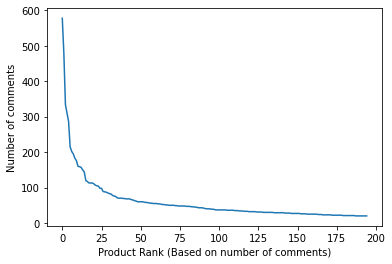

In [ ]:
comments_df = read_csv("comments.csv")
comments_df.drop_duplicates()["product_id"] \
    .value_counts().sort_values(ascending=False) \
    .reset_index(drop=True).plot(kind='line')
plt.xlabel("Product Rank (Based on number of comments)")
plt.ylabel("Number of comments")
plt.show()

> Save frequencies of each word in all the reviews in `word_frequencies.csv`

In [ ]:
tokens = comments_df["comment"].map(lambda s: word_tokenize(str(s).lower()))
tokens = tokens.map(lambda list_words: [i for i in list_words if i.isalpha() and i not in stop_words])
token_freq = Series(tokens.sum()).value_counts()
token_freq.to_csv("word_frequencies.csv")

In [ ]:
ip = input('Enter three features you are looking for in your cereal (space separated)')
attributes = nlp(ip)
display(ip)

'crunchy fruity sweet'

### Task C: Cosine similarity

> Define function to lemmatize all words in captions

In [ ]:
def lemmatization(text):
    text = nlp(text)
    text_lemma = [word.lemma_ for word in text]
    return " ".join(text_lemma)

> Lemmatize comments and store in another variable

In [ ]:
comments_df["comment_lemma"] = comments_df["comment"].map(lambda x: lemmatization(str(x)))
comments_df["comment"] = comments_df["comment"].map(str)

> Define `vectorize` and `cosine_similarity` functions

In [ ]:
def vectorize(sentence: str):
    return Series(word_tokenize(sentence.lower())).value_counts()

def cosine_similarity(vec_a: Series, vec_b: Series):
    super_index = set(list(vec_a.index) + list(vec_b.index))
    vec_a = vec_a.reindex(super_index).fillna(0)
    vec_b = vec_b.reindex(super_index).fillna(0)
    return np.dot(vec_a.sort_index(), vec_b.sort_index()) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


cosine_similarity(
    vectorize("""
(Team Breakfast Member)  Where did the flavor go? I used to eat these constantly in the 70's, and they had a sweet,
fruity and spicy flavor. I just bought a box to relive old memories, and they were almost completely tasteless;
like eating plain Cheerios without the oat flavor. No wonder Kellogg's is losing market share."""),
    vectorize(ip)
)

0.1111111111111111

> The sample output for a review of using the `cosine_similarity` function is as shown above. For the final recommendations, both Spacy and Cosine similarity are included in a single function and user will have the flexibility to select the algorithm. <br>
> **Full output in Section E*

### Task D: Sentiment Analysis

> Define sentiment analysis function for a given review `review_sentiment`, and a try a sample input

In [ ]:
senti_analyzer = SentimentIntensityAnalyzer()

def review_sentiment(review: str):
    score = senti_analyzer.polarity_scores(review)
    return score["compound"]

review_sentiment("""
Does anyone have a copy of the commercial that introduced brown sugar frosting?
It featured a speech choir for audio and simple line drawing animation in the form of wavy vertical lines and mouths.
The text went something like this:
A: Have you heard what's new? B: What's new? What's new?
A: The brand new taste of Alpha-Bits. They're brown sugar frosted. B: Brown sugar frosted?
A: Brown sugar makes these crispy letters, made from oats, golden. New golden Alpha-Bits are better than ever.B: Why are they better?
A: 'cause brown sugar makes 'em that way. B: What way?
A: Crisp, golden, and delicious. Now Alpha-Bits are more A-B-C-Delicious than ever. Than ever!
    And new golden Alpha-Bits have energy, from A to Z. You'll like 'em better than cereals with white sugar on 'em.
    Start your day a little bit better, A-B-C-Deliciously. Now you know what's new, don't you? B: Sure--Alpha-Bits.
    They have a new golden color and a brand new taste.
All: Now the only cereal with all the letters is the only cereal with brown sugar on 'em.
    New golden Alpha-Bits are better than ever. Than ever!""")

0.9765

> The sample output of the `review_sentiment` is as shown above. The final calculations of the sentiments of each review can be found in the Section E.

### Task F: Spacy word similarity

**Task E has been generalized in the next section below*

> Define a function to get spacy word similarity between the given attributes and the product review

In [ ]:
def get_spacy_word_vector_similarity(text):
    text = nlp(text)
    return attributes.similarity(text)

get_spacy_word_vector_similarity(
    """
    (Team Breakfast Member)  Where did the flavor go? I used to eat these constantly in the 70's, and they had a sweet,
    fruity and spicy flavor. I just bought a box to relive old memories, and they were almost completely tasteless;
    like eating plain Cheerios without the oat flavor. No wonder Kellogg's is losing market share."""
)

0.4047808879483893

> The sample output for a review of the `get_spacy_word_vector_similarity` has been shown above, the usage of this similarity has been defined in the section E below.

### Task E: Define a function to evaluate each cereal

Given,
* The type of analysis to be performed, i.e *bag of words* or *spacy word vector similarity*
    - `bool`: `True` for *bag of words*,  `False` for *Spacy word vector similarity*
* Include or exclude *Lemmatzation*
    - `bool`: `True` to use the previously lemmatized comments, `False` to use the comments as is

In [ ]:
def getTopRecommendation(input_attributes: str, bag_of_words: bool, lemma: bool = False):
    comment_col = "comment_lemma" if lemma else "comment"
    comments_df["sentiment_score"] = comments_df[comment_col].map(review_sentiment)
    if bag_of_words:
        comments_df["similarity_score"] = comments_df[comment_col].map(lambda x: cosine_similarity(vectorize(x), vectorize(input_attributes)))
    else:
        comments_df["similarity_score"] = comments_df[comment_col].map(get_spacy_word_vector_similarity)
    comments_df["final_score"] = comments_df["sentiment_score"]*comments_df["similarity_score"]

    evaluation_df = comments_df.groupby("product_id")[["final_score", "rating", "similarity_score", "sentiment_score"]].mean()
    evaluation_df = evaluation_df.reset_index() \
        .merge(read_csv("product_rating.csv").rename(columns={"rating": "rank"}), on="product_id", how="left") \
        .rename(columns={"rating": "avg_user_rating", "similarity_score": "avg_similarity_score", "sentiment_score": "avg_sentiment_score"})
    return evaluation_df

### Recommendation

#### Recommending Cereal based on 'Bag of Words Cosine Similarity'

In [ ]:
bow_df = getTopRecommendation(ip, bag_of_words=True).sort_values(by="final_score", ascending=False)
bow_df[:3]

,product_id,final_score,avg_user_rating,avg_similarity_score,avg_sentiment_score,rank,name
176,1177,0.025805,4.541667,0.031459,0.650354,164,Sweet Crunch Cereal
28,102,0.018727,4.161290,0.022137,0.625200,105,Cracklin' Oat Bran Cereal
26,100,0.017443,3.850000,0.020411,0.541045,1579,Corny-Snaps Cereal


> ##### Insights for Task E
> Logic for calculating the final score
> $$final\_score = Average(similarity\_score_i*sentiment\_score_i)$$
> The 3 products we would recommend the user are thus shown in the above table

#### Recommending Cereal based on 'SpaCy Word Vector Similarity'

In [ ]:
spacy_df = getTopRecommendation(ip, bag_of_words=False).sort_values(by="final_score", ascending=False)
spacy_df[:3]

,product_id,final_score,avg_user_rating,avg_similarity_score,avg_sentiment_score,rank,name
66,231,0.277700,4.960000,0.365322,0.751420,148,Marshmallow Krispies Cereal
42,159,0.259409,4.952381,0.363137,0.733657,1606,Fruit Harvest: Strawberry Blueberry Cereal
133,450,0.253073,4.437299,0.353288,0.701134,1645,Wheat Hearts Cereal


> ##### Insights for Task F
> For task F, we have used a medium sized pretrained word vectors. <br>
> The 3 cereals that we would recommend the user are as shown in the above table.
>  
> The cereals recommended in using spacy are all different from the ones recommended from BoW approach.
> The average similarity scores of the recommended cereals is much higher for the spacy output when compared to BoW cosine similarity since we are taking context into account and not just exact matches. The increase in similarity has also affected the final scores, and hence the difference in recommendations. <br>
>  
> The average user rating also seems to be better for the cereals recommended using spacy. Average user rating is calculated by us, as the average of all the individual review scores.

In [ ]:
def find_attribute_in_sentence(sentence, attributes):
    for attr in attributes:
        if attr in str(sentence).lower().split():
            return True
    return False

In [ ]:
# A deeper look into the BoW top-3 recommendation outputs
for idx in bow_df[:3].index:
    print("For product {name}:".format(name=bow_df.loc[idx,"name"]))
    for attr in ip.split():
        count = 100 * comments_df[comments_df["product_id"] == bow_df.loc[idx, "product_id"]]["comment"].map(lambda x: find_attribute_in_sentence(x, [attr])).sum() \
            / len(comments_df[comments_df["product_id"] == bow_df.loc[idx, "product_id"]])
        print(f"\tAttribute `{attr}` occurs in {count:.2f}% of the reviews")

For product Sweet Crunch Cereal:
	Attribute `crunchy` occurs in 0.00% of the reviews
	Attribute `fruity` occurs in 0.00% of the reviews
	Attribute `sweet` occurs in 29.17% of the reviews
For product Cracklin' Oat Bran Cereal:
	Attribute `crunchy` occurs in 6.45% of the reviews
	Attribute `fruity` occurs in 0.00% of the reviews
	Attribute `sweet` occurs in 9.68% of the reviews
For product Corny-Snaps Cereal:
	Attribute `crunchy` occurs in 15.00% of the reviews
	Attribute `fruity` occurs in 0.00% of the reviews
	Attribute `sweet` occurs in 5.00% of the reviews


In [ ]:
# A deeper look into the Spacy top-3 recommendation outputs
for idx in spacy_df[:3].index:
    print("For product {name}:".format(name=spacy_df.loc[idx,"name"]))
    for attr in ip.split():
        count = 100 * comments_df[comments_df["product_id"] == spacy_df.loc[idx, "product_id"]]["comment"].map(lambda x: find_attribute_in_sentence(x, [attr])).sum() \
            / len(comments_df[comments_df["product_id"] == spacy_df.loc[idx, "product_id"]])
        print(f"\tAttribute `{attr}` occurs in {count:.2f}% of the reviews")

For product Marshmallow Krispies Cereal:
	Attribute `crunchy` occurs in 0.00% of the reviews
	Attribute `fruity` occurs in 0.00% of the reviews
	Attribute `sweet` occurs in 12.00% of the reviews
For product Fruit Harvest: Strawberry Blueberry Cereal:
	Attribute `crunchy` occurs in 0.00% of the reviews
	Attribute `fruity` occurs in 0.00% of the reviews
	Attribute `sweet` occurs in 0.00% of the reviews
For product Wheat Hearts Cereal:
	Attribute `crunchy` occurs in 0.00% of the reviews
	Attribute `fruity` occurs in 0.00% of the reviews
	Attribute `sweet` occurs in 0.32% of the reviews


> From the top-3 recommendations of both BoW Cosine Similarity and Spacy (Word Vector) Similarity, we can see that, exact attribute matches are less for the latter method in comparison. But that is to be expected since in word vectors, we are adding the context, rather than relying on exact matches. These cereals would have never been recommended from the simple BoW Cosine Similarity. <br>
>  
> One review that stands out is *"Fruit Harvest: Strawberry Blueberry Cereal"* which has none of the user attributes mentioned. But we can clearly see that this is definitely a fruity cereal, just from the product name. Also the *"Marshmallow Krispies Cereal"* has sweet mentioned only in 12% of the reviews, but we can again intuitively predict that the cereal will be sweet since it's Marshmallow based.

### Task G: Top ranked products

#### Difference between top ranked products vs BoW similarity results

In [ ]:
print("Top Recommendations by BoW using Cosine Similarity")
display(bow_df.sort_values(by="final_score", ascending=False)[:3])
print("Top Recommendations by product ranking")
display(bow_df.sort_values(by="rank", ascending=True)[:3])

Top Recommendations by BoW using Cosine Similarity


,product_id,final_score,avg_user_rating,avg_similarity_score,avg_sentiment_score,rank,name
176,1177,0.025805,4.541667,0.031459,0.650354,164,Sweet Crunch Cereal
28,102,0.018727,4.161290,0.022137,0.625200,105,Cracklin' Oat Bran Cereal
26,100,0.017443,3.850000,0.020411,0.541045,1579,Corny-Snaps Cereal


Top Recommendations by product ranking


,product_id,final_score,avg_user_rating,avg_similarity_score,avg_sentiment_score,rank,name
92,300,0.000525,4.346939,0.000618,0.499678,1,Quisp Cereal
39,144,0.000000,3.515152,0.000000,0.402436,2,Frosted Flakes (Kellogg's) Cereal
172,1143,0.000262,4.717993,0.000485,0.637811,3,Concentrate Cereal


> The average similarity score and sentiment score of the top ranked (`rank` column as ranked on the website) cereals are lower than the ones that we suggest using Cosine Similarity. So these top ranked cereals would not match the specific requirements mentioned by the user. <br>
>  
> *Note:* `rank` is how the website has ranked the cereals based on their own metrics. `avg_user_rating` is calculated by us, given by the average of all the reviews left on the cereal's page.

#### Difference between top ranked products vs SpaCy similarity results

In [ ]:
print("Top Recommendations by Spacy Similarity")
display(spacy_df.sort_values(by="final_score", ascending=False)[:3])
print("Top Recommendations by product ranking")
display(spacy_df.sort_values(by="rank", ascending=True)[:3])

Top Recommendations by Spacy Similarity


,product_id,final_score,avg_user_rating,avg_similarity_score,avg_sentiment_score,rank,name
66,231,0.277700,4.960000,0.365322,0.751420,148,Marshmallow Krispies Cereal
42,159,0.259409,4.952381,0.363137,0.733657,1606,Fruit Harvest: Strawberry Blueberry Cereal
133,450,0.253073,4.437299,0.353288,0.701134,1645,Wheat Hearts Cereal


Top Recommendations by product ranking


,product_id,final_score,avg_user_rating,avg_similarity_score,avg_sentiment_score,rank,name
92,300,0.155791,4.346939,0.292304,0.499678,1,Quisp Cereal
39,144,0.131359,3.515152,0.275709,0.402436,2,Frosted Flakes (Kellogg's) Cereal
172,1143,0.224009,4.717993,0.343557,0.637811,3,Concentrate Cereal


> The average similarity score and sentiment score of the top ranked cereals using word vector similarity gives us a more nuanced recommender system than simply relying on the cereal rankings.

### Task H: Lift Analysis

> The most important features as we found from the `word_frequencies.csv` are shown in the dictionary keys, and the common substitute words used have also been mapped to the key from the reviews

In [ ]:
top_attributes = {
    "taste": ["taste", "delicious", "tastes", "tasted", "tasty"],
    "wheat": ["wheat", "wheats"],
    "sugar": ["sugar", "sweet", "sugary"],
    "rice": ["rice"]
}

> Define the function for lift analysis

In [ ]:
def getLift(product_id, attributes):
    N = len(comments_df)
    # Denominators - Adding a small number to the count to avoid zero denominator (if the case occurs)
    count_product = (comments_df["product_id"] == product_id).sum() + 10**(-6)
    count_attribute = comments_df["comment"].map(lambda x: find_attribute_in_sentence(x, attributes)).sum() + 10**(-6)
    # Numerator
    count_product_attribute = comments_df[comments_df["product_id"] == product_id]["comment"].map(lambda x: find_attribute_in_sentence(x, attributes)).sum()
    return N*count_product_attribute/(count_attribute*count_product)

> Picking out random 10 cereals and analyzing the closest 2 based on their association (lift scores) with the top 4 features.

In [ ]:
# import random
# randomlist = []
# for i in range(0,10):
#     n = random.randint(1,195)
#     randomlist.append(n)
# print(randomlist)

# Random 10 cereals from our cereal list
rand_cereals = [159, 98, 110, 79, 118, 147, 100, 71, 131, 97]

[140, 110, 139, 41, 141, 183, 48, 92, 89, 57]


In [ ]:
product_desc = comments_df.merge(read_csv("product_rating.csv").rename(columns={"rating": "rank"}), on="product_id", how="left")
product_desc = product_desc[["name", "product_id"]].drop_duplicates().iloc[rand_cereals]

for attr in top_attributes:
    product_desc["lift_"+attr] = product_desc["product_id"].map(lambda x: getLift(x, top_attributes[attr])).round(6)

product_desc

,name,product_id,lift_taste,lift_wheat,lift_sugar,lift_rice
9324,Oreo O's Cereal,270,0.641425,0.000000,0.178991,0.0
5928,Sweet Crunch Cereal,1177,0.000000,0.000000,7.830848,0.0
6669,Double Dip Crunch Cereal,129,0.464800,0.000000,1.167331,0.0
4956,S.W. Graham Cereal,367,0.745843,0.892566,0.624387,0.0
7534,Fruit Wheats Cereal,1328,0.000000,12.281704,0.000000,0.0
8840,Honey Graham Oh's Cereal,195,1.425388,0.000000,0.894954,0.0
6011,Team Cheerios Cereal,369,0.000000,0.000000,1.278506,0.0
4421,Raisin Nut Bran Cereal,305,0.534521,0.000000,0.000000,0.0
8064,Golden Grahams Cereal,168,2.915566,0.000000,2.440784,0.0
5874,Sun Flakes Cereal,364,0.395941,0.000000,1.988787,0.0


> From the above table, we chose **"Double Dip Crunch Cereal"** and the closest match for that cereal in this list was **"Sun Flakes Cereal"** because the order of attributes when sorted based on the lift scores is same for both. Additionally, both of them show strong association with sugar and a similar level of association with taste as an attribute. Both of them also do not seem to be associated with wheat and rice.